## Домашняя работа #4.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе: https://forms.gle/aFv9e2vd8FzC9VGi6

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.


Домашка на использование параметрических моделей.
* Ransac.
* Hough transform.


**Soft deadline: 21.04.2022 03:00:00 +0003 GMT**

**Hard deadline: 28.04.2022 03:00:00 +0003 GMT**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

# RANSAC

Ниже приведены блоки кода с помощью которых можно склеивать панорамы в единую картинку. 
* Извлекаем ключевые точки
* Сопоставляем похожие
* Ищем гомографию
* Склеиваем изображения

Гомография это обычное преобразование одник координат к другим с помощью матрицы. Мы должны с помощью `RANSAC` найти параметры этой матрицы. 
Для этого вы случайно берете `s` точек, по ним оцениваете значения $h_{11}$, .., $h_{33}$ считаете значние ошибки сопоставления на всех точках, etc 

# Скачиваем картинки

In [2]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

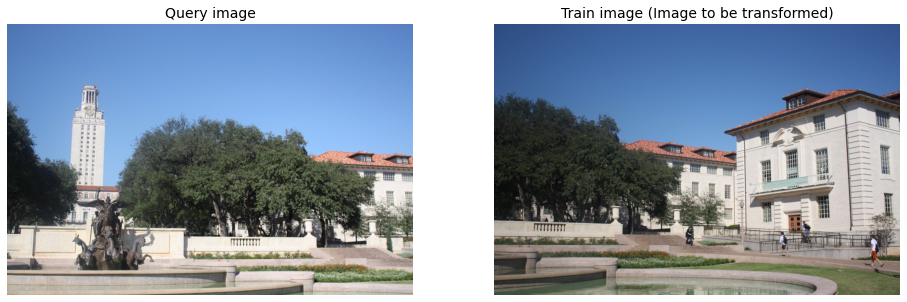

In [3]:
trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_title("Query image", fontsize=14)
ax1.axis('Off')

ax2.imshow(trainImg, cmap="gray")
ax2.set_title("Train image (Image to be transformed)", fontsize=14)
ax2.axis('Off')
plt.show()

# Ищем ключевые точки и вычисляем дексрипторы

In [4]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method

    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [5]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

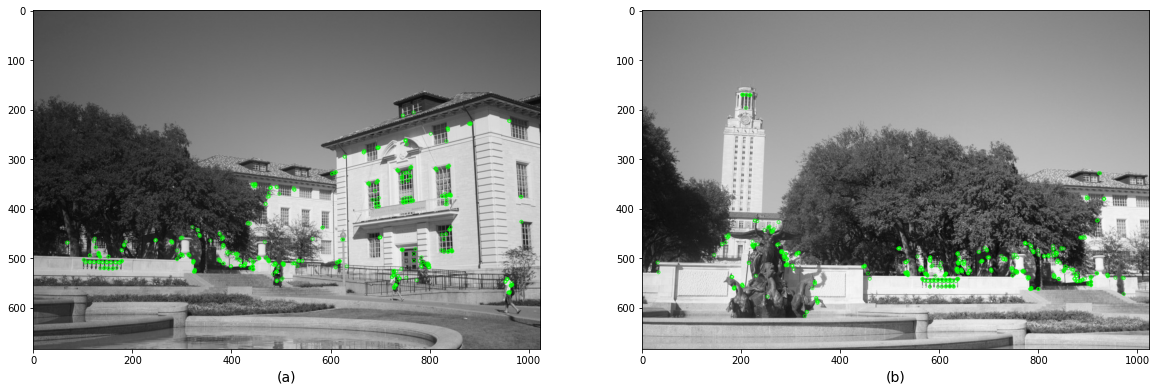

In [6]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(trainImg_gray, kpsA, None, color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(queryImg_gray, kpsB, None, color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

# Ищем похожие дескрипторы

In [7]:
def createMatcher(method, crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [8]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA, featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x : x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [9]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m, n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 186


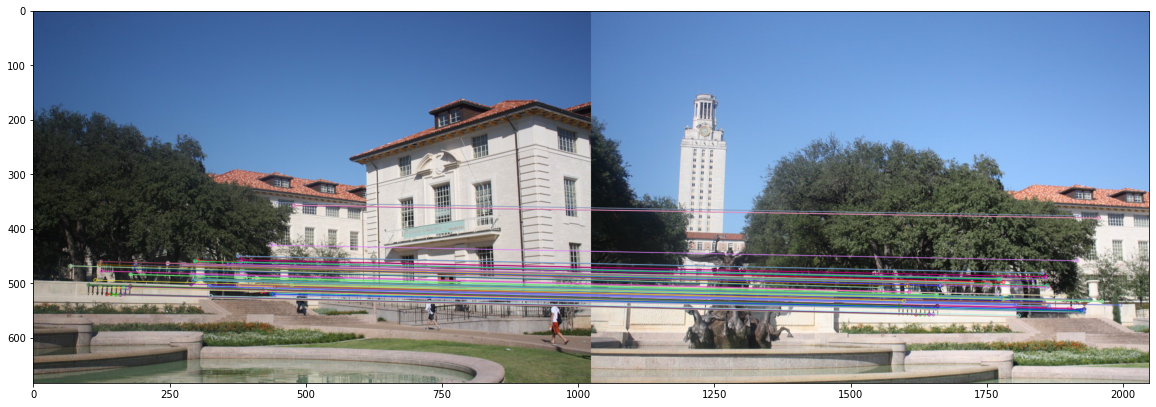

In [10]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg, kpsA, queryImg, kpsB, np.random.choice(matches,100),
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

# Сопоставление ключевых точек на изображении

In [11]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        return (matches, H, status)
    else:
        return None

In [12]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 8.18615992e-01  1.13260526e-01  4.27375823e+02]
 [-1.29788373e-01  9.97128543e-01  5.65078169e+01]
 [-2.01547290e-04  5.43423154e-05  1.00000000e+00]]


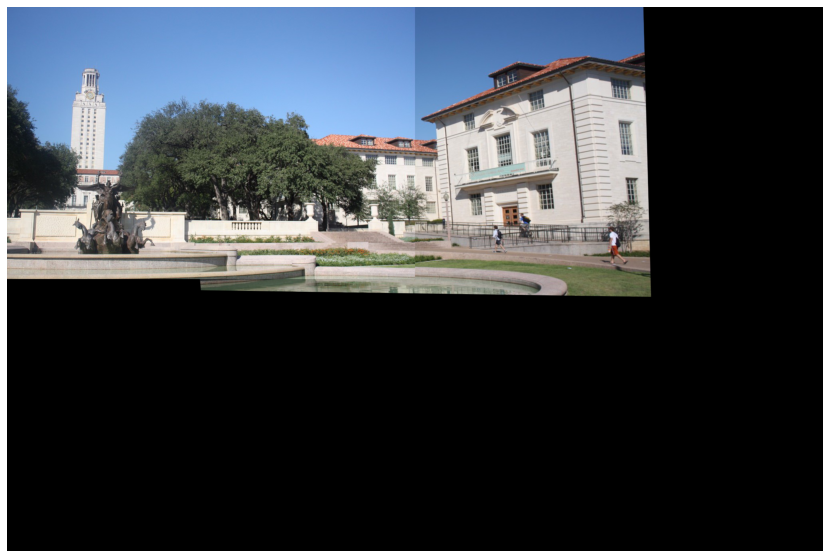

In [13]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

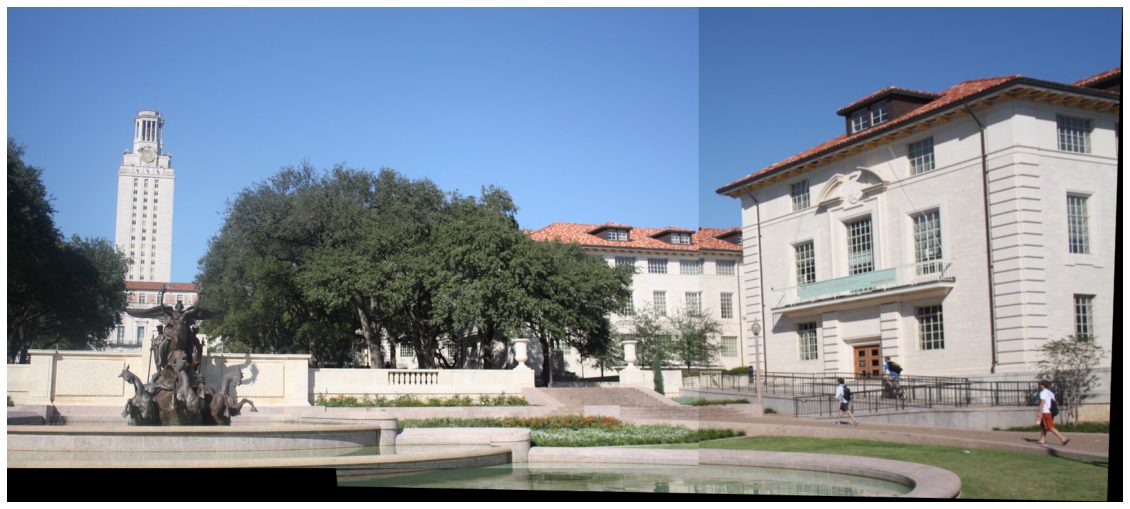

In [196]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.axis('Off')
plt.imshow(result);

**Задание 1. (20 баллов)**

Напишите свою функцию `findHomography` , которая принмает на вход список сопоставленных точек и использует `RANSAC` для определния матрицы гомографии. Примените вашу функцию и сравните результат. Склейте панораму используя матрицу гомографии. `RANSAC` тоже нужно имплементировать самостоятельно. 

In [192]:
# http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf
import numpy as np
from numpy import linalg as LA

# RANSAC loop:
# Select four feature pairs (at random)


def point_block(x, y, x1, y1):
    return np.array([
                   [x, y, 1, 0, 0, 0, -x1 * x, -x1 * y, -x1],
                   [0, 0, 0, x, y, 1, -y1 * x, -y1 * y, -y1]])


def compute_H(kpsA, kpsB):
    # Compute homography H (exact)
    A = np.vstack([point_block(x, y, x1, y1) for x, y, x1, y1 in np.hstack([kpsA, kpsB])])
    _, v = np.linalg.eigh(A.T @ A)
    h = v[:, 0]
    h = h.reshape((3, 3))
    return h # Checked


def compute_inliers(kpsA, kpsB, H, eps=1):
    # Compute inliers where ||pi’, H pi|| < ε
    n_samples, _ = kpsA.shape
    X = np.hstack([kpsA, np.ones((n_samples, 1))]).T
    Y = np.hstack([kpsB, np.ones((n_samples, 1))]).T
    res = H @ X
    res /= res[2, :] 
    inliers = (np.linalg.norm((res - Y), axis=0) < eps)  
    return np.arange(n_samples)[inliers]



def ransac(kpsA, kpsB, eps=1):
    n_inliers = 0
    n_samples, _ = kpsA.shape
    best_points = None
    N = float('inf')
    n_iter = 0
    while N > n_iter:
        # Достаточно 4 точек, т к у нас 9 параметров, 1 - свободный, 8 которые надо найти с помощью 8 уравнений или 4 пар точек 
        idx = np.random.randint(0, n_samples, 4)
        H = compute_H(kpsA[idx], kpsB[idx])
        model_inliers = compute_inliers(kpsA, kpsB, H, eps)
        count_inliers = min(1 - len(model_inliers) / n_samples, 0.99)
        N = np.log(1 - 0.99)/np.log(1 - (1 - count_inliers)**4)

        if n_inliers < len(model_inliers):
            n_inliers = len(model_inliers)
            best_points = model_inliers        
        n_iter += 1
    return compute_H(kpsA[best_points], kpsB[best_points])

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        H = ransac(ptsA, ptsB)

        return (matches, H)
    else:
        return None

In [193]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H) = M
print(H)

[[ 1.94295442e-03  3.68508545e-04  9.95065905e-01]
 [-3.44881002e-04  2.50224971e-03  9.91361073e-02]
 [-5.48127100e-07  2.70475101e-07  2.36354809e-03]]


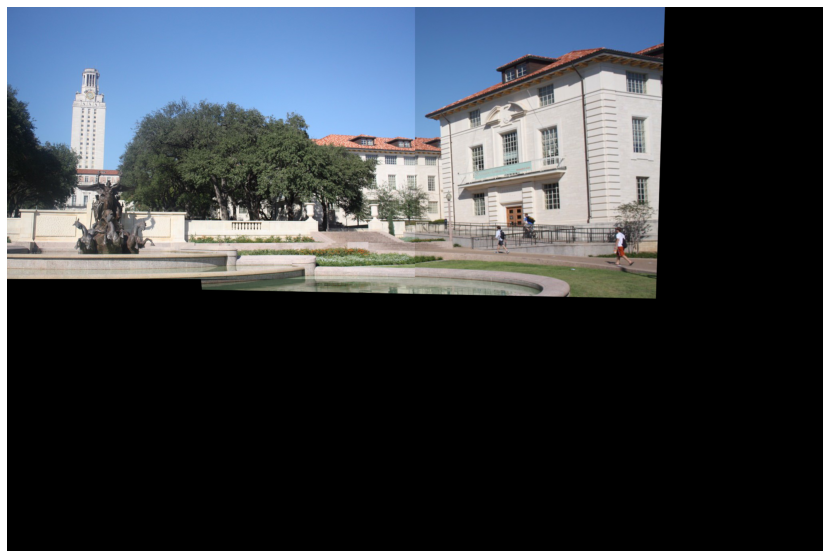

In [194]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

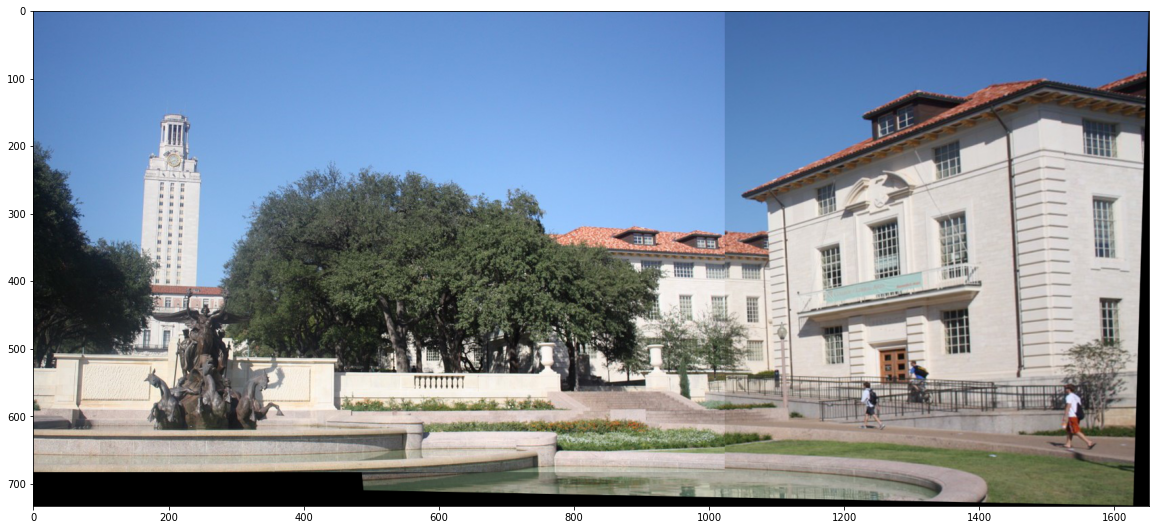

In [195]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result);

**Задание 2. (10 баллов)**

Напишите преобразование Хафа для поиска окружностей. Если для прямых мы делали трюк с превращением одного из параметров в cos для того, чтобы он был ограничен, то тут, кажется, нам надо перебрать координаты и всевозможные радиусы.  Примените его для поиска окружнойтей на изображении *сoins_noize_1.jpg* из предыдущего домашнего задания. Если не хотите перебирать руками все радиусы, то можно попробовать вдохновиться [этой работой](https://www.ecse.rpi.edu/~cvrl/Publication/pdf/Xie2002.pdf)

Сравните вашу функцию с функцией `cv.HoughCircles` по времени работы и по качеству. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib.pyplot import imread
from skimage.draw import circle_perimeter

from skimage.feature import canny
from skimage import data, color
from google.colab.patches import cv2_imshow

In [ ]:
def hough_circle(img, radius: np.ndarray):
    xmax, ymax = img.shape
    x, y = np.nonzero(img)
    num_pixels = x.size

    acc = np.zeros((radius.size, img.shape[0], img.shape[1]), dtype=np.float64)

    for i , rad in enumerate(radius):
        circle_x, circle_y = circle_perimeter(0, 0, rad)
        num_circle_pixels = circle_x.size
        
        for p in range(num_pixels):
        # Plug the circle at (px, py),
        # its coordinates are (tx, ty)
            for c in range(num_circle_pixels):
                tx = circle_x[c] + x[p]
                ty = circle_y[c] + y[p]
                if 0 <= tx < xmax and 0 <= ty < ymax:
                    acc[i, tx, ty] += 1
    return acc


def hough_circle_peaks(hough_res, hough_radii):
    center_circle = set()
    threshold = 0.5 * np.max(hough_res)
    for i, R in enumerate(hough_radii):
        h = hough_res[i, :, :]
        indices = np.where(h > threshold)

        for i, j in zip(indices[0], indices[1]):
            flg = True
            for x, y, r in center_circle:
                if np.sqrt((x - i) ** 2 + (y - j) ** 2) < r * 0.8:
                    flg = False
            if flg:
                center_circle.add((i, j, R))
    return center_circle



In [ ]:
file_path = '/content/drive/MyDrive/homework3-materials/coins_noize_2.jpg'
circles = cv2.imread(file_path, 0)
edges = canny(circles, sigma=3, low_threshold=10, high_threshold=50)

In [ ]:
%%time
hough_radii = np.arange(20, 50, 1)
hough_res = hough_circle(edges, hough_radii)
center_circle = hough_circle_peaks(hough_res, hough_radii)

CPU times: user 2min 51s, sys: 425 ms, total: 2min 51s
Wall time: 2min 59s


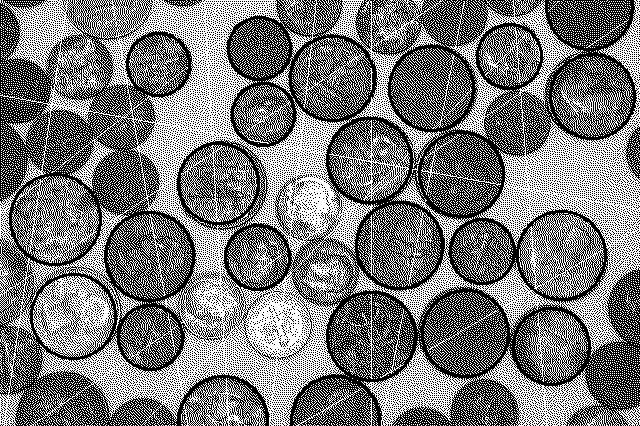

In [ ]:
img = circles.copy()
for i in center_circle:
    cv2.circle(img, (i[1], i[0]), i[2] - 2, (0, 255, 0), 2)
cv2_imshow(img)

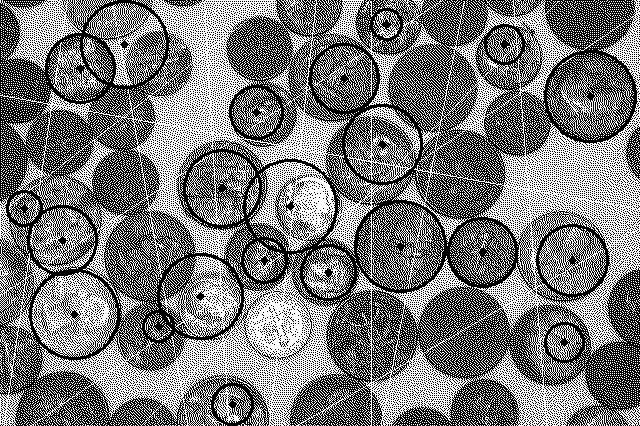

CPU times: user 189 ms, sys: 925 µs, total: 190 ms
Wall time: 159 ms


In [ ]:
%%time
img_init = cv2.imread(file_path, 0)
img = cv2.medianBlur(img_init, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1, 50,
                            param1=50, param2=30, minRadius=5, maxRadius=50)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img_init,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img_init,(i[0],i[1]),2,(0,0,255),3)
cv2_imshow(img_init) 

cv.HoughCircles работает быстрее, но кружки она нашла хуже. 